In [57]:
import glob
import os
import sys
import smrclib

In [58]:
try:
    sys.path.append(glob.glob('../carla/dist/carla-*%d.%d-%s.egg' % (
        sys.version_info.major,
        sys.version_info.minor,
        'win-amd64' if os.name == 'nt' else 'linux-x86_64'))[0])
except IndexError:
    pass

In [59]:
import carla
import random
import time
import numpy as np
import cv2
import open3d as o3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
SECONDS_PER_EPISODE = 12

In [60]:
def xxx():
    for actor in env.actor_list:
        actor.destroy()

In [61]:
class CarEnv:
    #BRAKE_AMT = 1.0

    actor_list = []
    collision_hist = []

    pt_cloud = []
    pt_cloud_filtered = []
    
    def __init__(self):
        self.client = carla.Client('localhost', 2000)
        self.client.set_timeout(2.0)

        self.world = self.client.get_world()

        blueprint_library = self.world.get_blueprint_library()

        self.model_3 = blueprint_library.filter('model3')[0]
        self.truck_2 = blueprint_library.filter('carlamotors')[0]
        
    def reset(self):
        self.collision_hist = []
        self.actor_list = []
        self.pt_cloud = []
        self.pt_cloud_filtered = []

        transform = carla.Transform(carla.Location(-120,115,3),carla.Rotation(0,-90,0))

        self.vehicle = self.world.spawn_actor(self.model_3, transform)
        
        self.actor_list.append(self.vehicle)

        self.lidar_sensor = self.world.get_blueprint_library().find('sensor.lidar.ray_cast')
        self.lidar_sensor.set_attribute('points_per_second', '100000')
        self.lidar_sensor.set_attribute('channels', '32')
        self.lidar_sensor.set_attribute('range', '10000')
        self.lidar_sensor.set_attribute('upper_fov', '10')
        self.lidar_sensor.set_attribute('lower_fov', '-10')
        self.lidar_sensor.set_attribute('rotation_frequency', '60')

        transform = carla.Transform(carla.Location(x=0, z=1.9))
        self.sensor = self.world.spawn_actor(self.lidar_sensor, transform, attach_to=self.vehicle)

        self.actor_list.append(self.sensor)
        self.sensor.listen(lambda data: self.process_lidar(data))

        self.vehicle.apply_control(carla.VehicleControl(throttle=1, brake=0.0))
        self.episode_start = time.time()


        time.sleep(4) # sleep to get things started and to not detect a collision when the car spawns/falls from sky.
        
        transform2 = carla.Transform(carla.Location(x=2.5, z=0.7))
        colsensor = self.world.get_blueprint_library().find('sensor.other.collision')
        self.colsensor = self.world.spawn_actor(colsensor, transform2, attach_to=self.vehicle)
        self.actor_list.append(self.colsensor)
        self.colsensor.listen(lambda event: self.collision_data(event))

        while self.distance_to_obstacle is None:
            time.sleep(0.01)

        self.episode_start = time.time()

        self.vehicle.apply_control(carla.VehicleControl(throttle=1, brake=0.0))
        
        return int(self.distance_to_obstacle//1)

    def collision_data(self, event):
        self.collision_hist.append(event)

    def process_lidar(self, raw):
        points = np.frombuffer(raw.raw_data, dtype=np.dtype('f4'))
        points = np.reshape(points, (int(points.shape[0] / 3), 3))*np.array([1,-1,-1])
        lidar_data = points.astype(np.int32)
        self.pt_cloud.append(lidar_data)

        #screen points specifically -4<y<4 and 0<x<12
        pt = points[np.logical_and(points[:,0] > -3, points[:,0] < 3)]
        points_filter = pt[np.logical_and(pt[:,1] > 0, pt[:,1] < 50)]
        points_filter = points_filter[np.logical_and(points_filter[:,1] > 0, points_filter[:,1] < 50)]
        self.pt_cloud_filtered.append(points_filter)

        if len(points_filter) == 0:
            pass
        else:
            self.distance_to_obstacle = min(points_filter[:,1])-2.247148275375366

    def step(self, action):

        v = self.vehicle.get_velocity()
        kmh = int(3.6 * math.sqrt(v.x**2 + v.y**2 + v.z**2))
        
        if action == 0:
            self.vehicle.apply_control(carla.VehicleControl(throttle=1.0, brake=0.0, steer = 0.0))
        elif action == 1:
            while kmh != 0:
                self.vehicle.apply_control(carla.VehicleControl(throttle=0.0, brake=1.0, steer = 0.0))
                ##print(kmh)
                v = self.vehicle.get_velocity()
                kmh = int(3.6 * math.sqrt(v.x**2 + v.y**2 + v.z**2))
                ##print("distance_to_obstacle = ",self.distance_to_obstacle)
                
        # ถ้ารถชน หรือ รถหยุดแล้ว
        if kmh == 0 or len(self.collision_hist) != 0 :
            done = True
            print('DISTANCE FOR REWARD')
            print(self.distance_to_obstacle)
            if  0<= self.distance_to_obstacle <1 and len(self.collision_hist) != 0 :
                reward = -1
            elif  0<= self.distance_to_obstacle <1:
                reward = 1
            elif  1<= self.distance_to_obstacle <2:
                reward = 1.5
            elif  2<= self.distance_to_obstacle <3:
                reward = 0.45
            elif  3<= self.distance_to_obstacle <4:
                reward = 0.32
            elif  4<= self.distance_to_obstacle <5:
                reward = 0.20
            elif  5<= self.distance_to_obstacle <6:
                reward = -0.15
            elif  6<= self.distance_to_obstacle <7:
                reward = -0.8
            elif  7<= self.distance_to_obstacle <8:
                reward = -1.5
            elif  8<= self.distance_to_obstacle :
                reward = -3
        else:
            done = False
            reward = 0.5
        
        if self.episode_start + SECONDS_PER_EPISODE < time.time():
            done = True
            reward = -1
            dist = 0
            
        dist=int(abs(self.distance_to_obstacle//1))
            

        return dist,reward, done, None

In [62]:
env = CarEnv()

# action มี 2 อันคือ เบรคและเร่งเต็มที่, state มี 13 อัน คือ ชน, 0-1, 1-2, 2-3, 3-4, 4-5, 5-6, 6-7, 7-8, 8-9, 9-10, 10-11, >11
action_space_size = 2
state_space_size = 10
#q_table = np.zeros((state_space_size, action_space_size))

num_episodes = 300
max_steps_per_episode = 100
learning_rate = 0.1
discount_rate = 0.99

exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.01

count = 0
rewards_all_episodes = []
action_all_episodes = []

for episode in range(num_episodes):
    state = env.reset()
      
    print('LOOP START : time')
    print(time.time()-env.episode_start)
    done = False
    rewards_current_episode = []
    action_current_episode = []
    count_step=0
    
    for step in range(max_steps_per_episode):
        exploration_rate_threshold = random.uniform(0, 1)
        if exploration_rate_threshold > exploration_rate:
            action = np.argmax(q_table[state,:]) 
        else:
            action = np.random.randint(0, high=2, size=None, dtype='int')
        action_current_episode.append(action)
        new_state, reward, done, info = env.step(action)
        print('[UPDATED]')
        print(new_state,reward,done,info)
        if new_state > 8 :
            new_state = 8
        q_table[state, action] = q_table[state, action] * (1 - learning_rate) + \
            learning_rate * (reward + discount_rate * np.max(q_table[new_state, :]))
        count_step+=1
        state = new_state
        rewards_current_episode.append(reward)
                    
        if done == True:
            print(q_table)
            print('destroying actors')
            for actor in env.actor_list:
                actor.destroy()
            count+=1
            print('episode number = ',count)
            print('distance to obstacle = ',state)
            print('rewards_current_episode = ',rewards_current_episode)
            print('action_current_episode =', action_current_episode)
            print('count_step = ', count_step)
            break            
        
    # Exploration rate decay
    exploration_rate = min_exploration_rate + \
          (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*episode)
    print('exploration rate: '+str(exploration_rate))

    rewards_all_episodes.append(rewards_current_episode)
    action_all_episodes.append(action_current_episode)

LOOP START : time
0.0
DISTANCE FOR REWARD
0.19373106956481934
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542415]
 [ 0.05       -0.12430589]
 [ 1.6722469  -0.57470102]
 [ 1.71618289  0.06933105]
 [49.99300531  1.96897879]
 [49.37267201  0.27837086]]
destroying actors
episode number =  1
distance to obstacle =  0
rewards_current_episode =  [-1]
action_current_episode = [1]
count_step =  1
exploration rate: 1.0
LOOP START : time
0.0
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
DISTANCE FOR REWARD
0.14995670318603516
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542415]
 [ 0.05       -0.12430589]
 [ 1.81708522 -0.58265507]
 [ 1.71618289  0.06933105]
 [49.99300531  1.96897879]
 [49.37267201  0.27837086]]
destroying actors
episode number =  2
di

LOOP START : time
0.0
[UPDATED]
6 0.5 False None
DISTANCE FOR REWARD
0.1871635913848877
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542415]
 [ 0.05       -0.26791844]
 [ 2.3921107  -0.63177693]
 [ 1.71618289  0.06933105]
 [49.99300531  1.96897879]
 [49.37267201  0.27837086]]
destroying actors
episode number =  16
distance to obstacle =  0
rewards_current_episode =  [0.5, -1]
action_current_episode = [0, 1]
count_step =  2
exploration rate: 0.8621008966608072
LOOP START : time
0.0
[UPDATED]
6 0.5 False None
DISTANCE FOR REWARD
0.1560194492340088
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542415]
 [ 0.05       -0.26791844]
 [ 2.43971859 -0.63402338]
 [ 1.71618289  0.06933105]
 [49.99300531  1.96897879]
 [49.37267201  0.27837086]]
destroying actors
episode number =  17
distan

LOOP START : time
0.0
[UPDATED]
5 0.5 False None
[UPDATED]
5 0.5 False None
[UPDATED]
5 0.5 False None
[UPDATED]
5 0.5 False None
[UPDATED]
5 0.5 False None
DISTANCE FOR REWARD
0.18323945999145508
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542415]
 [ 0.44820419 -0.37261199]
 [ 3.19500241 -0.64719189]
 [ 1.71618289  0.06933105]
 [49.99300531  1.96897879]
 [49.37267201  0.27837086]]
destroying actors
episode number =  30
distance to obstacle =  0
rewards_current_episode =  [0.5, 0.5, 0.5, 0.5, 0.5, -1]
action_current_episode = [0, 0, 0, 0, 0, 1]
count_step =  6
exploration rate: 0.7507809319027796
LOOP START : time
0.0009975433349609375
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
DISTA

LOOP START : time
0.0
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
DISTANCE FOR REWARD
0.22362279891967773
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542415]
 [ 0.44820419 -0.44893359]
 [ 4.80563225 -0.65178346]
 [ 1.71618289  0.06933105]
 [49.99300531  1.96897879]
 [49.37267201  0.27837086]]
destroying actors
episode number =  43
distance to obstacle =  0
rewards_current_episode =  [0.5, 0.5, 0.5, 0.5, -1]
action_current_episode = [0, 0, 0, 0, 1]
count_step =  5
exploration rate: 0.6604763516169062
LOOP START : time
0.0
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
DISTANCE FOR REWARD
0.2080061435699463
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542415]
 [ 0.44820419 -0.44893359]
 [ 4.89597579 -0.6520

LOOP START : time
0.000997781753540039
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
DISTANCE FOR REWARD
0.20596742630004883
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542415]
 [ 0.54725823 -0.4879421 ]
 [ 6.36083792 -0.65347015]
 [ 1.71618289  0.06933105]
 [49.99300531  1.96897879]
 [49.37267201  0.27837086]]
destroying actors
episode number =  56
distance to obstacle =  0
rewards_current_episode =  [0.5, 0.5, -1]
action_current_episode = [0, 0, 1]
count_step =  3
exploration rate: 0.5811803122766818
LOOP START : time
0.0
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
DISTANCE FOR REWARD
0.21641254425048828
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542415]
 [ 0.54725823 -0.48

LOOP START : time
0.0
[UPDATED]
6 0.5 False None
DISTANCE FOR REWARD
0.2618074417114258
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542415]
 [ 0.64611426 -0.51953899]
 [ 7.56638093 -0.65402365]
 [ 1.71618289  0.06933105]
 [49.99300531  1.96897879]
 [49.37267201  0.27837086]]
destroying actors
episode number =  70
distance to obstacle =  0
rewards_current_episode =  [0.5, -1]
action_current_episode = [0, 1]
count_step =  2
exploration rate: 0.5065603083753949
LOOP START : time
0.0009982585906982422
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
DISTANCE FOR REWARD
0.18036150932312012
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542415]
 [ 0.64611426 -0.51953899]
 [ 7.69355453 -0.65404544]
 [ 1.71618289  0.06933105]
 [49.99300531  1.96897879]


LOOP START : time
0.0
[UPDATED]
6 0.5 False None
DISTANCE FOR REWARD
0.23421335220336914
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542415]
 [ 0.89239065 -0.53300924]
 [ 8.9445152  -0.65417998]
 [ 1.71618289  0.06933105]
 [49.99300531  1.96897879]
 [49.37267201  0.27837086]]
destroying actors
episode number =  83
distance to obstacle =  0
rewards_current_episode =  [0.5, -1]
action_current_episode = [0, 1]
count_step =  2
exploration rate: 0.44602733796093924
LOOP START : time
0.0
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
DISTANCE FOR REWARD
0.21152806282043457
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542415]
 [ 0.89239065 -0.53300924]
 [ 9.02658511 -0.65418613]
 [ 1.71618289  0.06933105]
 [49.99300531  1.96897879]
 [49.37267201  0.27837086]]
destroying acto

LOOP START : time
0.0
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
DISTANCE FOR REWARD
0.24865269660949707
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542415]
 [ 0.89239065 -0.53300924]
 [10.35729572 -0.65422743]
 [ 1.71618289  0.06933105]
 [49.99300531  1.96897879]
 [49.37267201  0.27837086]]
destroying actors
episode number =  97
distance to obstacle =  0
rewards_current_episode =  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, -1]
action_current_episode = [0, 0, 0, 0, 0, 0, 1]
count_step =  7
exploration rate: 0.38906395711536096
LOOP START : time
0.0
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
DISTANCE FOR REWARD
0.20196294784545898
[

DISTANCE FOR REWARD
0.21671080589294434
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542415]
 [ 0.89239065 -0.53300924]
 [12.89046643 -0.65423709]
 [ 1.71618289  0.06933105]
 [49.99300531  1.96897879]
 [49.37267201  0.27837086]]
destroying actors
episode number =  108
distance to obstacle =  0
rewards_current_episode =  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, -1]
action_current_episode = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
count_step =  18
exploration rate: 0.34957843224451957
LOOP START : time
0.0009980201721191406
DISTANCE FOR REWARD
0.24073028564453125
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542415]
 [ 0.89239065 -0.53300924]
 [12.89046643 -0.65423754]
 [ 1.71618289  0.06933105]
 [49.99300531  1.96897879

LOOP START : time
0.0009961128234863281
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
DISTANCE FOR REWARD
0.25299835205078125
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542415]
 [ 1.13743811 -0.56586318]
 [14.70120281 -0.65423997]
 [ 1.71618289  0.06933105]
 [49.99300531  1.96897879]
 [49.37267201  0.27837086]]
destroying actors
episode number =  121
distance to obstacle =  0
rewards_current_episode =  [0.5, 0.5, 0.5, 0.5, 0.5, -1]
action_current_episode = [0, 0, 0, 0, 0, 1]
count_step =  6
exploration rate: 0.3081822697930801
LOOP START : time
0.0
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
DISTANCE FOR REWARD
0.20678257942199707
[UPDATED]
0 -1 Tru

LOOP START : time
0.0
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
DISTANCE FOR REWARD
0.23405146598815918
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542

DISTANCE FOR REWARD
0.18481922149658203
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542415]
 [ 1.81708522 -0.58981371]
 [19.86251226 -0.65424125]
 [ 1.71618289  0.06933105]
 [49.99300531  1.96897879]
 [49.37267201  0.27837086]]
destroying actors
episode number =  141
distance to obstacle =  0
rewards_current_episode =  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, -1]
action_current_episode = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
count_step =  17
exploration rate: 0.2541309943021904
LOOP START : time
0.0
[UPDATED]
6 0.5 False None
DISTANCE FOR REWARD
0.19624567031860352
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542415]
 [ 1.81708522 -0.58981371]
 [19.89264975 -0.65424128]
 [ 1.71618289  0.06933105]
 [49.99300531  1.96897879

DISTANCE FOR REWARD
0.1916813850402832
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542415]
 [ 2.77164346 -0.59625649]
 [21.18928629 -0.65424143]
 [ 1.71618289  0.06933105]
 [49.99300531  1.96897879]
 [49.37267201  0.27837086]]
destroying actors
episode number =  153
distance to obstacle =  0
rewards_current_episode =  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, -1]
action_current_episode = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
count_step =  21
exploration rate: 0.22652476808269262
LOOP START : time
0.0
[UPDATED]
5 0.5 False None
[UPDATED]
5 0.5 False None
[UPDATED]
5 0.5 False None
[UPDATED]
5 0.5 False None
[UPDATED]
5 0.5 False None
[UPDATED]
5 0.5 False None
[UPDATED]
5 0.5 False None
[UPDATED]
5 0.5 False None
[UPDATED]
5 0.5 False None
[UPDATED]
5 0.5 False None
DISTANCE FOR REWARD
0.204054117

DISTANCE FOR REWARD
0.2023177146911621
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542415]
 [ 3.2418074  -0.60205499]
 [23.43201832 -0.65424148]
 [ 1.71618289  0.06933105]
 [49.99300531  1.96897879]
 [49.37267201  0.27837086]]
destroying actors
episode number =  162
distance to obstacle =  0
rewards_current_episode =  [0.5, -1]
action_current_episode = [0, 1]
count_step =  2
exploration rate: 0.20788873793439305
LOOP START : time
0.0
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
DISTANCE FOR REWARD
0.19805073738098145
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542415]
 [ 3.241807

DISTANCE FOR REWARD
0.22963547706604004
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542415]
 [ 4.57898091 -0.61197043]
 [25.10481844 -0.6542415 ]
 [ 1.71618289  0.06933105]
 [49.99300531  1.96897879]
 [49.37267201  0.27837086]]
destroying actors
episode number =  172
distance to obstacle =  0
rewards_current_episode =  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, -1]
action_current_episode = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
count_step =  19
exploration rate: 0.1890571346909509
LOOP START : time
0.0
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
DISTANCE FOR REWARD
0.19280219078063965
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542415]
 [ 4.57898091 -0.61197043]
 [25.1794

LOOP START : time
0.0009975433349609375
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
DISTANCE FOR REWARD
0.24025797843933105
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542415]
 [ 6.22965816 -0.61619754]
 [27.06570828 -0.6542415 ]
 [ 1.71618289  0.06933105]
 [49.99300531  1.96897879]
 [49.37267201  0.27837086]]
destroying actors
episode number =  180
distance to obstacle =  0
rewards_current_episode =  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, -1]
action_current_episode = [0, 0, 0, 0, 0, 0, 0, 0, 1]
count_step =  9
exploration rate: 0.1752905679703703
LOOP START : time
0.0
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATE

LOOP START : time
0.00099945068359375
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
DISTANCE FOR REWARD
0.2550313472747803
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542415]
 [ 8.19844893 -0.62650746]
 [28.6383401  -0.65424151]
 [ 1.71618289  0.06933105]
 [49.99300531  1.96897879]
 [49.37267201  0.27837086]]
destroying actors
episode number =  189
distance to obstacle =  0
rewards_current_episode =  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,

LOOP START : time
0.0
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
DISTANCE FOR REWARD
0.19735312461853027
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542415]
 [ 8.28201023 -0.62928086]
 [28.6103487  -0.65424151]
 [ 1.71618289  0.06933105]
 [49.99300531  1.96897879]
 [49.37267201  0.27837086]]
destroying actors
episode number =  198
distance to obstacle =  0
rewards_current_episode =  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, -1]
action_current_episode = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
count_step =  12
exploration rate: 0.14806228765290044
LOOP START : time
0.0
[UPDATED]
5 0.5 False None
[UPDATED]
5 0.5 False None

LOOP START : time
0.0
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
DISTANCE FOR REWARD
0.24909639358520508
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542415]
 [10.27789123 -0.63402338]
 [29.9370426  -0.65424151]
 [ 1.71618289  0.06933105]
 [49.99300531  1.96897879]
 [49.37267201  0.27837086]]
destroying actors
epi

DISTANCE FOR REWARD
0.18122029304504395
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542415]
 [13.37000641 -0.6395025 ]
 [29.09009124 -0.65424151]
 [ 1.71618289  0.06933105]
 [49.99300531  1.96897879]
 [49.37267201  0.27837086]]
destroying actors
episode number =  213
distance to obstacle =  0
rewards_current_episode =  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, -1]
action_current_episode = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
count_step =  37
exploration rate: 0.12883131222634217
LOOP START : time
0.0
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
DISTANCE FOR REWARD
0.18644976615905762
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]

DISTANCE FOR REWARD
0.21500182151794434
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542415]
 [15.43511154 -0.64230291]
 [30.15013646 -0.65424151]
 [ 1.71618289  0.06933105]
 [49.99300531  1.96897879]
 [49.37267201  0.27837086]]
destroying actors
episode number =  221
distance to obstacle =  0
rewards_current_episode =  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, -1]
action_current_episode = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
count_step =  25
exploration rate: 0.11969512677871053
LOOP START : time
0.0
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
DISTANCE FOR REWARD
0.2463827133178711
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542415]
 [15.43511154 -

LOOP START : time
0.0
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
DISTANCE FOR REWARD
0.20084118843078613
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542415]
 [15.91588712 -0.64457124]
 [30.39552551 -0.65424151]
 [ 1.71618289  0.06933105]
 [49.99300531  1.96897879]
 [49.37267201  0.27837086]]
destroying actors
episode number =  230
distance to obstacle =  0
rewards_current_episode =  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, -1]
action_current_episode = [0, 0, 

LOOP START : time
0.0009975433349609375
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
DISTANCE FOR REWARD
0.21271681785583496
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542415]
 [16.28894335 -0.64640859]
 [30.65530676 -0.65424151]
 [ 1.71618289  0.06933105]
 [49.99300531  1.96897879]
 [49.37267201  0.27837086]]
destroying actors
episode number =  238
distance to obstacle =  0
rewards_current_episode =  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, -1]
action_current_episode = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
count_step =  12
exploration rate: 0.10254591901527788
LOOP START : time
0.0
[UPDATED]
6 0.5 False None
[UPDATED

LOOP START : time
0.0
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
DISTANCE FOR REWARD
0.17610931396484375
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542415]
 [16.95679765 -0.64789685]
 [30.18787353 -0.65424151]
 [ 1.71618289  0.06933105]
 [49.99300531  1.96897879]
 [49.37267201  0.27837086]]
destroying actors
episode number =  244
distance to obstacle =  0
rewards_current_episode =  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, -1]
action_current_episode = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
count_step =  13
exploration rate: 0.09715646425654882
LOOP START : time
0.0
[UPDATED]
6 0.5 Fa

LOOP START : time
0.0
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
DISTANCE FOR REWARD
0.2676122188568115
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542415]
 [16.95679765 -0.64789685]
 [32.41168681 -0.65424151]
 [ 1.71618289  0.06933105]
 [49.99300531  1.96897879]
 [49.37267201  0.27837086]]
destroying actors
episode number =  252
distance to obstacle =  0
rewards_current_episode =  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, -1]
action_current_episode = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
count_step =  11
exploration rate: 0.09045555684848275
LOOP START : time
0.0
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED

DISTANCE FOR REWARD
0.1965329647064209
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542415]
 [17.05582816 -0.64853131]
 [34.4793388  -0.65424151]
 [ 1.71618289  0.06933105]
 [49.99300531  1.96897879]
 [49.37267201  0.27837086]]
destroying actors
episode number =  259
distance to obstacle =  0
rewards_current_episode =  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, -1]
action_current_episode = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
count_step =  14
exploration rate: 0.08501626398261702
LOOP START : time
0.0
DISTANCE FOR REWARD
0.20954346656799316
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542415]
 [17.05582816 -0.64853131]
 [34.4793388  -0.65424151]
 [ 1.71618289  0.06933105]
 [49.99300531  1.96897879]
 [49.37267201  0.27837086]]
destroying actors
epi

LOOP START : time
0.0
[UPDATED]
6 0.5 False None
DISTANCE FOR REWARD
0.16878056526184082
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542415]
 [17.74078111 -0.64910233]
 [35.61574664 -0.65424151]
 [ 1.71618289  0.06933105]
 [49.99300531  1.96897879]
 [49.37267201  0.27837086]]
destroying actors
episode number =  268
distance to obstacle =  0
rewards_current_episode =  [0.5, -1]
action_current_episode = [0, 1]
count_step =  2
exploration rate: 0.07855970305625253
LOOP START : time
0.0
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None

LOOP START : time
0.0
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
DISTANCE FOR REWARD
0.21563100814819336
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542415]
 [18.78847716 -0.65007878]
 [34.14704615 -0.65424151]
 [ 1.71618289  0.06933105]
 [49.99300531  1.96897879]
 [49.37267201  0.27837086]]
destroying actors
episode number =  273
distance to obstacle =  0
rewards_current_episode =  [0.5, 0.5, -1]
action_current_episode = [0, 0, 1]
count_step =  3
exploration rate: 0.07521600688213892
LOOP START : time
0.0
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 Fa

DISTANCE FOR REWARD
0.23698639869689941
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542415]
 [19.37618905 -0.6508697 ]
 [33.51199286 -0.65424151]
 [ 1.71618289  0.06933105]
 [49.99300531  1.96897879]
 [49.37267201  0.27837086]]
destroying actors
episode number =  277
distance to obstacle =  0
rewards_current_episode =  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, -1]
action_current_episode = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
count_step =  20
exploration rate: 0.07265885067604429
LOOP START : time
0.0
[UPDATED]
5 0.5 False None
[UPDATED]
5 0.5 False None
[UPDATED]
5 0.5 False None
[UPDATED]
5 0.5 False None
[UPDATED]
5 0.5 False None
[UPDATED]
5 0.5 False None
[UPDATED]
5 0.5 False None
[UPDATED]
5 0.5 False None
[UPDATED]
5 0.5 False None
[UPDATED]
5 0.5 False None
DISTANCE FOR REWARD
0.0093309879302978

DISTANCE FOR REWARD
0.18711233139038086
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542415]
 [21.33305204 -0.65202926]
 [32.42684982 -0.65424151]
 [ 1.71618289  0.06933105]
 [49.99300531  1.96897879]
 [49.37267201  0.27837086]]
destroying actors
episode number =  284
distance to obstacle =  0
rewards_current_episode =  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, -1]
action_current_episode = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
count_step =  50
exploration rate: 0.06842272513275337
LOOP START : time
0.0
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.

DISTANCE FOR REWARD
0.2677791118621826
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542415]
 [21.70349452 -0.65225049]
 [34.70841568 -0.65424151]
 [ 1.71618289  0.06933105]
 [49.99300531  1.96897879]
 [49.37267201  0.27837086]]
destroying actors
episode number =  289
distance to obstacle =  0
rewards_current_episode =  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, -1]
action_current_episode = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
count_step =  14
exploration rate: 0.06557341520579238
LOOP START : time
0.000997304916381836
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 

DISTANCE FOR REWARD
0.2003183364868164
[UPDATED]
0 -1 True None
[[ 0.349251    0.20832748]
 [ 1.62387077 -0.73807624]
 [ 0.99055676 -0.59842658]
 [ 0.          0.        ]
 [ 0.         -0.06542415]
 [24.52530057 -0.65262878]
 [34.66804166 -0.65424151]
 [ 1.71618289  0.06933105]
 [49.99300531  1.96897879]
 [49.37267201  0.27837086]]
destroying actors
episode number =  293
distance to obstacle =  0
rewards_current_episode =  [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, -1]
action_current_episode = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
count_step =  27
exploration rate: 0.06339435042735246
LOOP START : time
0.0
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]


LOOP START : time
0.0
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
6 0.5 False None
[UPDATED]
5 0.5 False None
[UPDATED]
5 0.5 False None
[UPDATED]
5 0.5 False None
[UPDATED]
5 0.5 False None
[UPDAT

In [63]:
xxx()
reward

1.5

10 : -0.55
20 : -1.2
30 : -1.0
40 : -0.55
50 : -0.8
60 : 0.3
70 : 0.1
80 : 0.65
90 : 0.9
100 : 1.5
110 : 3.3
120 : 4.55
130 : 7.95
140 : 10.6
150 : 12.2
160 : 16.45
170 : 19.45
180 : 25.85
190 : 30.95
200 : 37.2
210 : 42.4
220 : 49.6
230 : 55.1
240 : 60.3
250 : 69.4
260 : 77.1
270 : 85.1
280 : 98.5
290 : 113.1
300 : 133.95


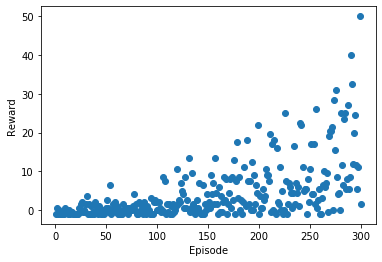

In [64]:
a=rewards_all_episodes
n = 0 
count = 0
n_list=[]
count_list=[]
for i in a :
    for j in i:
        count += j
    count_list.append(sum(i))
    n+=1
    n_list.append(n)
    if n%10 == 0:
        print(n,':',str(count/10)) 
        
ax=plt.scatter(n_list,count_list,marker='o')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

In [65]:
b=action_all_episodes
step = []
episode=[]
n=1
for i in b:
    step.append(len(i))
    episode.append(n)
    n+=1
print(step)
print(episode)

[1, 4, 1, 3, 1, 2, 1, 1, 1, 4, 3, 2, 1, 3, 1, 2, 2, 1, 1, 1, 1, 1, 4, 2, 6, 7, 2, 3, 2, 6, 10, 1, 6, 1, 5, 1, 2, 1, 7, 5, 3, 1, 5, 3, 1, 1, 3, 1, 3, 4, 8, 4, 2, 16, 1, 3, 6, 3, 7, 2, 5, 1, 1, 3, 1, 1, 6, 3, 3, 2, 4, 1, 4, 3, 3, 5, 11, 3, 6, 1, 1, 7, 2, 3, 5, 1, 7, 3, 1, 5, 2, 3, 1, 9, 1, 1, 7, 8, 7, 3, 3, 7, 4, 2, 3, 20, 2, 18, 1, 6, 2, 6, 1, 5, 1, 6, 2, 3, 5, 24, 6, 8, 7, 17, 13, 11, 4, 20, 4, 8, 30, 2, 4, 22, 6, 2, 1, 4, 8, 4, 17, 2, 1, 1, 16, 1, 6, 3, 11, 4, 7, 4, 21, 11, 17, 6, 30, 12, 6, 1, 15, 2, 10, 2, 7, 20, 8, 19, 1, 6, 12, 19, 4, 20, 8, 29, 1, 18, 38, 9, 20, 3, 8, 1, 7, 25, 5, 39, 18, 6, 18, 3, 28, 3, 21, 6, 16, 12, 47, 1, 10, 4, 4, 14, 8, 10, 24, 21, 21, 18, 42, 2, 37, 3, 39, 2, 1, 35, 7, 6, 25, 3, 13, 1, 3, 53, 18, 1, 6, 17, 15, 12, 4, 12, 36, 6, 17, 12, 15, 5, 48, 47, 25, 13, 14, 14, 1, 19, 7, 24, 37, 11, 11, 37, 6, 55, 4, 8, 14, 1, 1, 9, 16, 23, 15, 17, 22, 2, 41, 44, 44, 46, 3, 60, 34, 65, 20, 11, 12, 3, 53, 26, 16, 50, 53, 14, 19, 57, 14, 20, 83, 68, 27, 43, 52, 26, 14,

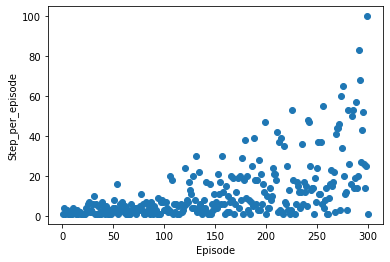

In [66]:
ax=plt.scatter(episode,step,marker='o')
plt.xlabel('Episode')
plt.ylabel('Step_per_episode')
plt.show()

In [67]:
q_table

array([[ 0.349251  ,  0.20832748],
       [ 1.77224689, -0.73807624],
       [ 0.99055676, -0.59842658],
       [ 0.        ,  0.        ],
       [ 0.        , -0.06542415],
       [27.15730793, -0.6529352 ],
       [34.00748832, -0.65424151],
       [ 1.71618289,  0.06933105],
       [49.99300531,  1.96897879],
       [49.37267201,  0.27837086]])